# <font color='darkblue'> Sparkify Small Dataset Models and Evaluation</font>

<div class="alert alert-block alert-info">

This notebook is dedicated to the following tasks:
    <li> , </li>
    <li> fea, </li>
    <li> EDAata, </li>
    <li> stratified split of the data into training and test sets </li>
    <li> feature relevance and feature selection considerations.</li>
</div>

## <font color='blue'>Set Environment</font>

In [1]:
# import PySpark libraries and packages

import pyspark
from pyspark import SparkContext
from pyspark import SparkConf

from pyspark.sql import SparkSession
from pyspark.sql.window import Window as W

from pyspark.sql.types import (
    StringType,
    IntegerType, 
    DateType, 
    TimestampType,
    )

from pyspark.sql.functions import (
    min as Fmin, max as Fmax, 
    sum as Fsum, round as Fround, 
    
    col, lit, 
    first, last, 
    desc, asc,
    avg, count, countDistinct, 
    when, isnull, isnan,
    from_unixtime, 
    datediff,
    )

# libraries and packages for modeling

from pyspark.ml import Pipeline

from pyspark.ml.feature import (
    StringIndexer, 
    OneHotEncoder, 
    VectorAssembler, 
    StandardScaler
)
from pyspark.ml.feature import (
    OneHotEncoder, 
    OneHotEncoderModel
)

from pyspark.ml.classification import (
    LogisticRegression,
    DecisionTreeClassifier,
    RandomForestClassifier,
    GBTClassifier,
    MultilayerPerceptronClassifier,
    LinearSVC,
    NaiveBayes
)

from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

In [4]:
# build a Spark session using the SparkSession APIs

spark = (SparkSession
        .builder
        .appName("Sparkify")
        .getOrCreate())

spark.sparkContext.setLogLevel("ERROR")

In [5]:
# import python libraries

import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# import sklearn metrics related packages

from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc, roc_curve, roc_auc_score

In [6]:
# import library for enhanced plotting

import seaborn as sns
sns.set_style("darkgrid")
colors = sns.color_palette('PuBuGn_r')

## <font color='blue'>Load Train and Test Datasets</font>

In [7]:
def load_data(file_path):
    """
    Loads the raw dataset in Spark.
    
    INPUT:
            (str) - path for datafile
    OUTPUT:
            (PySpark dataframe) - dataframe of raw data
    
    """
    
    print("Loading the dataset ...")
    df = spark.read.json(file_path)
    print("Dataset is loaded...")
    
    return df


In [8]:
def save_data(df, data_path):
    """
    Saves the PySpark dataframe to a file.
    
    INPUT:
            df (PySpark dataframe) - data to be saved
            data_path (str) - path for datafile
    OUTPUT:
            none
    
    """
    
    df.write.json(data_path)

In [9]:
# path for the train set file
path_trainset = "data/full_sparkify_train_data.json"

# upload the train data
df_train = load_data(path_trainset)

# check the upload
df_train.count()

Loading the dataset ...


Dataset is loaded...


15438

In [ ]:
# path for the test set file file
path_testset = "data/full_sparkify_test_data.json"

# upload the test data
df_test = load_data(path_testset)

# check the upload
df_test.count()

### <font color='blue'>Toggle the memory</font>

In [10]:
# add the train set to the memory
train_cached = df_train.cache()

In [ ]:
# add the test set to the memory
#test_cached = df_test.persist()

## <font color='blue'>Modeling</font>

<div class="alert alert-block alert-info">

Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

</div>

### <font color='blue'>Baseline Model</font>

In [11]:
# count the number of churn users in each set
fn_train = train_cached.where(train_cached.churn==1).count()
#fn_test = test_cached.where(test_cached.churn==1).count()

# count the number of not churn users in each set
tn_train = train_cached.where(train_cached.churn==0).count()
#tn_test = test_cached.where(test_cached.churn==0).count()

In [12]:
# accuracy of ZeroR model on train set
accuracy_train = tn_train/(fn_train+tn_train)
print("With fp = tp = 0, fn = {} and tn = {}, the accuracy of the ZeroR model on the train set is {}%."
      .format(fn_train, tn_train, round(accuracy_train,4)*100))

# accuracy of ZeroR model on test set
#accuracy_test = tn_test/(fn_test+tn_test)
#print("With fp = tp = 0, fn = {} and tn = {}, the accuracy of the ZeroR model on the test set is {}%."
#      .format(fn_test, tn_test, round(accuracy_test,4)*100))

With fp = tp = 0, fn = 3443 and tn = 11995, the accuracy of the ZeroR model on the train set is 77.7%.


<div class="alert alert-block alert-info">
    
Build a ZeroR baseline model. This is a simple model that always predicts the most numerous class. The accuracy of this model on the test set is:

$${\rm accuracy\;testset} = \frac{\rm not\; churn}{\rm all\; users} = \frac{46}{58} = 0.79$$
    
Any classifier we build must have better accuracy on the test set than the accuracy of this dummy classifier.
    
</div>

### <font color='blue'>Build Models Evaluators</font>

In [13]:
# function to compute relevant metrics for binary classification
def conf_metrics(dataset):
    
    """
        Calculates the metrics associated to the confusion matrix.

        INPUT:
            dataset (pyspark.sql.DataFrame) - a dataset that contains
                                labels and predictions
        OUTPUT:
            accuracy (float) - metric
            precision (float) - metric
            recall (float) - metric
            F1 (float) - metric
    """
   

    # calculate the elements of the confusion matrix
    tn = dataset.where((dataset[labelCol]==0) & (dataset[predCol]==0)).count()
    tp = dataset.where((dataset[labelCol]==1) & (dataset[predCol]==1)).count()                   
    fn = dataset.where((dataset[labelCol]==1) & (dataset[predCol]==0)).count()                   
    fp = dataset.where((dataset[labelCol]==0) & (dataset[predCol]==1)).count()
    
    # calculate accuracy, precision, recall, and F1-score
    accuracy = (tn + tp) / (tn + tp + fn + fp)
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    f1 =  2 * (precision*recall) / (precision + recall)
    
    return accuracy, precision, recall, f1

In [14]:
# function to display the metrics of interest
def display_metrics(dataset, roc_cl, pr_cl):
    
    """
    Prints evaluation metrics for the model. 
    
    INPUT:
         dataset (pyspark.sql.DataFrame) - a dataset that contains
                                labels and predictions
    
    """
    
    accuracy = conf_metrics(dataset)[0]
    precision = conf_metrics(dataset)[1]
    recall = conf_metrics(dataset)[2]
    f1 = conf_metrics(dataset)[3]
    
    print("")
    print("Confusion Matrix")
    dataset.groupBy(dataset[labelCol], dataset[predCol]).count().show()
    print("")
    print("accuracy...............%6.3f" % accuracy)
    print("precision..............%6.3f" % precision)
    print("recall.................%6.3f" % recall)
    print("F1.....................%6.3f" % f1)
    print("auc_roc................%6.3f" % roc_cl)
    print("auc_pr.................%6.3f" % pr_cl)


In [15]:
# source: https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python

def plot_roc_pr_curves(predictions, model_name):
    
    """
    Calculates ROC-AUC and PR-AUC scores and plots the ROC and PR curves.
    
    INPUT:
        predictions (PySpark dataframe) - contains probability predictions, label column
        model_name (str) - classifier name
        
    OUTPUT:
        none - two plots are displayed
        
    """
    
    # transform predictions PySpark dataframe into Pandas dataframe
    pred_pandas = predictions.select(predictions.label, predictions.probability).toPandas()
    
    # calculate roc_auc score
    roc_auc = roc_auc_score(pred_pandas.label, pred_pandas.probability.str[1])
    # generate a no skill prediction (majority class)
    ns_probs = [0 for _ in range(len(pred_pandas.label))]
    # calculate roc curves
    fpr, tpr, _ = roc_curve(pred_pandas.label, pred_pandas.probability.str[1])
    ns_fpr, ns_tpr, _ = roc_curve(pred_pandas.label, ns_probs)
    
    # calculate precision, recall for each threshold
    precision, recall, _ = precision_recall_curve(pred_pandas.label, pred_pandas.probability.str[1])
    # calculate pr auc score
    pr_auc = auc(recall, precision)
    

    # create figure which contains two subplots
    plt.figure(figsize=[12,6])
    
    plt.subplot(121)
    
    # plot the roc curve for the model
    plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
    plt.plot(fpr, tpr, marker='.', label='ROC AUC = %.3f' % (roc_auc))
    
    # axis labels
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    # show the legend
    plt.legend()
    # figure title
    plt.title("ROC Curve:" + model_name)
    
    plt.subplot(122)
    
    # plot the precision-recall curves
    
    ns_line = len(pred_pandas[pred_pandas.label==1]) / len(pred_pandas.label)
    plt.plot([0, 1], [ns_line, ns_line], linestyle='--', label='No Skill')
    plt.plot(recall, precision, marker='.', label='PR AUC = %.3f' % (pr_auc))
    
    # axis labels
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    # show the legend
    plt.legend()
    # figure title
    plt.title("Precision-Recall Curve:" + model_name)

    # show the plot
    plt.show()

### <font color='blue'>Build Pipelines</font>

In [16]:
# split the features and the label
CAT_FEATURES = ["level"]
CONT_FEATURES = ["nr_songs", "nr_likes", "nr_dislikes", "nr_friends", "nr_downgrades",
                "nr_upgrades", "nr_error", "nr_settings", "nr_ads", "nr_sessions",
                "n_acts", "acts_per_session", "songs_per_session", "ads_per_session",
                "init_days_interv", "tenure_days_interv", "active_days"]
CHURN_LABEL = "churn"

def build_full_pipeline(classifier):
    """
    Combines all the stages of the processing and modeling.
    """
    # stages in the pipeline
    stages = [] 
    
    # encode the labels
    label_indexer =  StringIndexer(inputCol=CHURN_LABEL, outputCol="label")
    stages += [label_indexer]
    
    # encode the binary features
    bin_assembler = VectorAssembler(inputCols=CAT_FEATURES, outputCol="bin_features")
    stages += [bin_assembler]
    
    # encode the continuous features
    cont_assembler = VectorAssembler(inputCols = CONT_FEATURES, outputCol="cont_features")
    stages += [cont_assembler]
    # normalize the continuous features
    cont_scaler = StandardScaler(inputCol="cont_features", outputCol="cont_scaler", 
                                 withStd=True , withMean=True)
    stages += [cont_scaler]
    
    # pass all to the vector assembler to create a single sparse vector
    all_assembler = VectorAssembler(inputCols=["bin_features", "cont_scaler"],  
                            outputCol="features")
    stages += [all_assembler]
    
    # add the model to the pipeline
    stages += [classifier]
    
    # create a pipeline
    pipeline = Pipeline(stages=stages)
    
    return pipeline

In [17]:
# implement K-fold cross validation and grid search 

def grid_search_model(pipeline, param):
    """
    Creates a cross validation object and performs grid search
    over a set of parameters.
    
    INPUT:
        param = grid of parameters
        pipeline = model pipeline 
    
    OUTPUT:
        cv = cross validation object
    """
    evaluator = BinaryClassificationEvaluator()
    cv = CrossValidator(estimator=pipeline,
                    estimatorParamMaps=param,
                    evaluator=evaluator,
                    numFolds=5,
                    parallelism=2)
    return cv

## <font color='blue'>Evaluate PySpark Classifiers</font>

<div class="alert alert-block alert-info">

Fit the binary classifiers from PySpark on the train set with cross validation and default parameters to select the best ones for the next stage.
   
</div>

### <font color='blue'>Logistic Regression Classifier</font>

In [18]:
# Logistic Regression model

# create grid search with cross validation
def lr_grid_search(pipeline):
    
    model = pipeline.getStages()[-1]

    # create a list of parameters for Logistic Regression
    param_lr = ParamGridBuilder()
    param_lr = param_lr.addGrid(model.regParam, [0.0])
    param_lr = param_lr.addGrid(model.elasticNetParam, [0.0])
    param_lr = param_lr.build()
    
    print(f"Models trained: {len(param_lr)}")
    
    return grid_search_model(pipeline, param_lr)


Training LOGISTIC REGRESSION CLASSIFIER

Models trained: 1

Training time......... 0.352 min


Confusion Matrix
+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|  1.0|       1.0| 2065|
|  0.0|       1.0|  689|
|  1.0|       0.0| 1378|
|  0.0|       0.0|11306|
+-----+----------+-----+


accuracy............... 0.866
precision.............. 0.750
recall................. 0.600
F1..................... 0.666
auc_roc................ 0.889
auc_pr................. 0.755

The best hyperparameter values from the grid:
regNetParam:.......... 0.0
elasticNetParam:...... 0.0


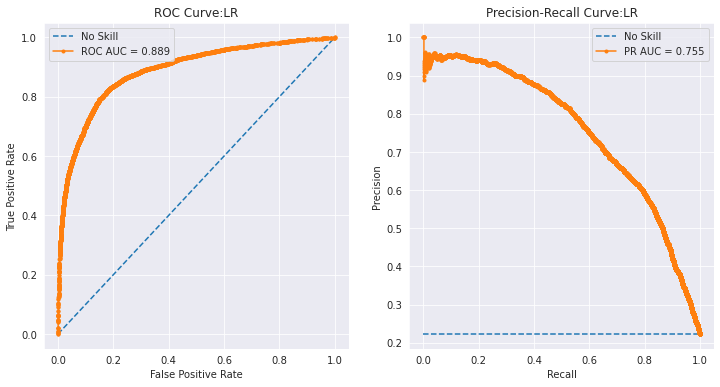

In [19]:
print("")
print(f"Training LOGISTIC REGRESSION CLASSIFIER")
print("")

predCol="prediction"
labelCol="label"

# instantiate the classifier
lr_classifier = LogisticRegression(labelCol = "label",
                                       featuresCol = "features")

# build specific pipeline
lr_pipeline = build_full_pipeline(lr_classifier)

# choose an evaluator
evaluator = BinaryClassificationEvaluator()
evaluator.setLabelCol(labelCol)

# build the grid search pipeline
lr = lr_grid_search(lr_pipeline)

# start timer
start_time = time.time()

# train the model
model_lr = lr.fit(train_cached)

# stop timer
end_time = time.time()

# evaluate the trainining time in minutes 
train_time = (end_time - start_time)/60

# print the training time
print("")
print("Training time.........%6.3f min" % train_time)

# create the predictions dataset
predictions_lr = model_lr.bestModel.transform(train_cached)

# calculate auc metrics
roc_lr = evaluator.evaluate(predictions_lr, {evaluator.metricName: "areaUnderROC"})
pr_lr = evaluator.evaluate(predictions_lr, {evaluator.metricName: "areaUnderPR"})

# record the confusion matrix metrics
acc_lr, prec_lr, rec_lr, f1_lr = conf_metrics(predictions_lr)

# print all evaluation metrics
print("")
display_metrics(predictions_lr, roc_lr, pr_lr)
print("")

# print the best parameters from the grid
best_model_lr = model_lr.bestModel.stages[-1]
param_lr1 = best_model_lr.getRegParam()
param_lr2 = best_model_lr.getElasticNetParam()
print("The best hyperparameter values from the grid:")
print("regNetParam:..........", param_lr1)
print("elasticNetParam:......", param_lr2)

# plot the ROC and PR curves
plot_roc_pr_curves(predictions_lr, "LR")

### <font color='blue'>Decision Trees Classifier</font>

In [20]:
# model_name = "Decision Trees"
def dt_grid_search(pipeline):
    
    model = pipeline.getStages()[-1]

    # create a list of parameters for Decision Trees
    param_dt = ParamGridBuilder()
    param_dt = param_dt.addGrid(model.maxDepth, [5]) 
    param_dt = param_dt.addGrid(model.maxBins, [32])
    param_dt = param_dt.build()
    
    print(f"Models trained: {len(param_dt)}")
    
    return grid_search_model(pipeline, param_dt)


Training DECISION TREES CLASSIFIER

Models trained: 1

Training time......... 0.094 min


Confusion Matrix
+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|  1.0|       1.0| 1973|
|  0.0|       1.0|  320|
|  1.0|       0.0| 1470|
|  0.0|       0.0|11675|
+-----+----------+-----+


accuracy............... 0.884
precision.............. 0.860
recall................. 0.573
F1..................... 0.688
auc_roc................ 0.717
auc_pr................. 0.586

The best hyperparameter values from the grid:
maxDepth:.......... 5
maxBins:........... 32


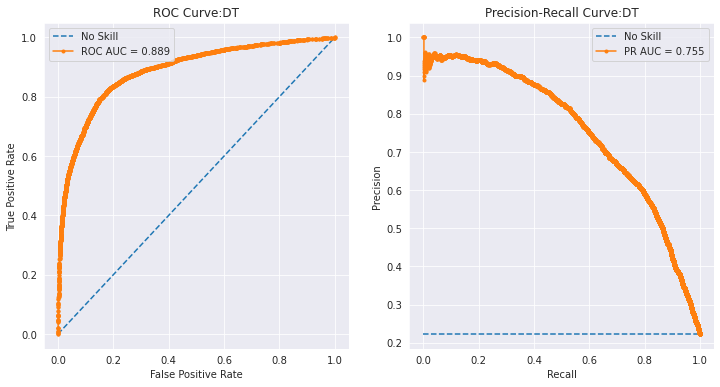

In [21]:
print("")
print(f"Training DECISION TREES CLASSIFIER")
print("")

predCol="prediction"
labelCol="label"

# build specific pipeline
dt_classifier = DecisionTreeClassifier(labelCol = "label",
                                           featuresCol = "features",
                                           seed=1234)
dt_pipeline = build_full_pipeline(dt_classifier)


# choose an evaluator
evaluator = BinaryClassificationEvaluator()
evaluator.setLabelCol(labelCol)

# build the grid search pipeline
dt = dt_grid_search(dt_pipeline)

# start timer
start_time = time.time()

# train the model
model_dt = dt.fit(train_cached)

# stop timer
end_time = time.time()

# evaluate the trainining time in minutes 
train_time = (end_time - start_time)/60

# print the training time
print("")
print("Training time.........%6.3f min" % train_time)

# create the predictions dataset
predictions_dt = model_dt.bestModel.transform(train_cached)

# calculate auc metrics
roc_dt = evaluator.evaluate(predictions_dt, {evaluator.metricName: "areaUnderROC"})
pr_dt = evaluator.evaluate(predictions_dt, {evaluator.metricName: "areaUnderPR"})

# record the confusion matrix metrics
acc_dt, prec_dt, rec_dt, f1_dt = conf_metrics(predictions_dt)

# print all evaluation metrics
print("")
display_metrics(predictions_dt, roc_dt, pr_dt)
print("")

# print the best parameters from the grid
best_model_dt = model_dt.bestModel.stages[-1]
param_dt1 = best_model_dt.getMaxDepth()
param_dt2 = best_model_dt.getMaxBins()
print("The best hyperparameter values from the grid:")
print("maxDepth:..........", param_dt1)
print("maxBins:...........", param_dt2)

# plot the ROC and PR curves
plot_roc_pr_curves(predictions_lr, "DT")

### <font color='blue'>Random Forest Classifier</font>

In [22]:
# model_name = "Random Forest"
def rf_grid_search(pipeline):
    
    model = pipeline.getStages()[-1]

    # create a list of parameters for Random Forest
    param_rf = ParamGridBuilder()
    param_rf = param_rf.addGrid(model.maxDepth, [5]) 
    param_rf = param_rf.addGrid(model.maxBins, [32])
    param_rf = param_rf.addGrid(model.numTrees, [20]) 
    param_rf = param_rf.build()
    
    print(f"Models trained: {len(param_rf)}")
    
    return grid_search_model(pipeline, param_rf)


Training RANDOM FOREST CLASSIFIER

Models trained: 1

Training time......... 0.103 min


Confusion Matrix
+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|  1.0|       1.0| 1770|
|  0.0|       1.0|  260|
|  1.0|       0.0| 1673|
|  0.0|       0.0|11735|
+-----+----------+-----+


accuracy............... 0.875
precision.............. 0.872
recall................. 0.514
F1..................... 0.647
auc_roc................ 0.899
auc_pr................. 0.788

The best hyperparameter values from the grid:
maxDepth:.......... 5
maxBins:........... 32
numTrees:.......... 20


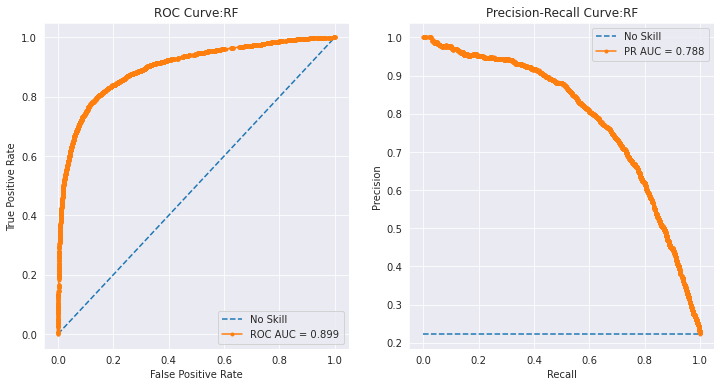

In [23]:
print("")
print(f"Training RANDOM FOREST CLASSIFIER")
print("")

predCol="prediction"
labelCol="label"

# instantiate the classifier
rf_classifier = RandomForestClassifier(labelCol = "label",
                                           featuresCol = "features", 
                                           seed=1234)
# build the specific pipeline
rf_pipeline = build_full_pipeline(rf_classifier)

# choose an evaluator
evaluator = BinaryClassificationEvaluator()
evaluator.setLabelCol(labelCol)

# build the grid search pipeline
rf = rf_grid_search(rf_pipeline)

# start timer
start_time = time.time()

# train the model
model_rf = rf.fit(train_cached)

# stop timer
end_time = time.time()

# evaluate the trainining time in minutes 
train_time = (end_time - start_time)/60

# print the training time
print("")
print("Training time.........%6.3f min" % train_time)

# create the predictions dataset
predictions_rf = model_rf.bestModel.transform(train_cached)

# calculate auc metrics
roc_rf = evaluator.evaluate(predictions_rf, {evaluator.metricName: "areaUnderROC"})
pr_rf = evaluator.evaluate(predictions_rf, {evaluator.metricName: "areaUnderPR"})

# record the confusion matrix metrics
acc_rf, prec_rf, rec_rf, f1_rf = conf_metrics(predictions_rf)

# print all evaluation metrics
print("")
display_metrics(predictions_rf, roc_rf, pr_rf)
print("")

best_param_rf = list(model_rf.getEstimatorParamMaps()[np.argmax(model_rf.avgMetrics)].values())
print("The best hyperparameter values from the grid:")
print("maxDepth:..........", best_param_rf[0])
print("maxBins:...........", best_param_rf[1])
print("numTrees:..........", best_param_rf[2])

# plot the ROC and PR curves
plot_roc_pr_curves(predictions_rf, "RF")

### <font color='blue'>Gradient Boosted Trees</font>

In [24]:
# model_name = "Gradient Boosted Trees"
def gbt_grid_search(pipeline):
    
    model = pipeline.getStages()[-1]

    # create a list of parameters for Gradient Boosted Trees
    param_gbt = ParamGridBuilder()
    param_gbt = param_gbt.addGrid(model.maxDepth, [5])
    param_gbt = param_gbt.addGrid(model.maxIter, [20])
    param_gbt = param_gbt.addGrid(model.stepSize, [.1])
    param_gbt = param_gbt.build()
    
    print(f"Models trained: {len(param_gbt)}")
    
    return grid_search_model(pipeline, param_gbt)


Training GRADIENT BOOSTED TREES

Models trained: 1

Training time......... 0.448 min


Confusion Matrix
+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|  1.0|       1.0| 2348|
|  0.0|       1.0|  339|
|  1.0|       0.0| 1095|
|  0.0|       0.0|11656|
+-----+----------+-----+


accuracy............... 0.907
precision.............. 0.874
recall................. 0.682
F1..................... 0.766
auc_roc................ 0.934
auc_pr................. 0.866

The best hyperparameter values from the grid:
maxDepth:.......... 5
maxIter:........... 20
stepSize:.......... 0.1


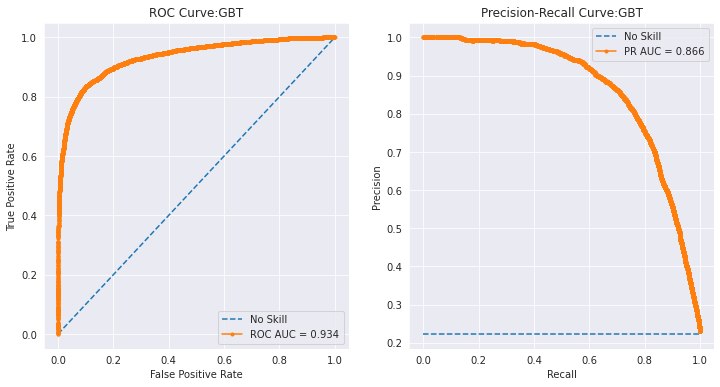

In [25]:
print("")
print(f"Training GRADIENT BOOSTED TREES")
print("")

predCol="prediction"
labelCol="label"

# instantiate the classifier
gbt_classifier = GBTClassifier(labelCol = "label",
                                featuresCol = "features",
                                seed=1234)
# build specific pipeline
gbt_pipeline = build_full_pipeline(gbt_classifier)

# choose an evaluator
evaluator = BinaryClassificationEvaluator()
evaluator.setLabelCol(labelCol)

# build the grid search pipeline
gbt = gbt_grid_search(gbt_pipeline)

# start timer
start_time = time.time()

# train the model
model_gbt = gbt.fit(train_cached)

# stop timer
end_time = time.time()

# evaluate the trainining time in minutes 
train_time = (end_time - start_time)/60

# print the training time
print("")
print("Training time.........%6.3f min" % train_time)

# create the predictions dataset
predictions_gbt = model_gbt.bestModel.transform(train_cached)

# calculate auc metrics
roc_gbt = evaluator.evaluate(predictions_gbt, {evaluator.metricName: "areaUnderROC"})
pr_gbt = evaluator.evaluate(predictions_gbt, {evaluator.metricName: "areaUnderPR"})

# record the confusion matrix metrics
acc_gbt, prec_gbt, rec_gbt, f1_gbt = conf_metrics(predictions_gbt)

# print all evaluation metrics
print("")
display_metrics(predictions_gbt, roc_gbt, pr_gbt)
print("")

# print the best parameters from the grid
best_model_gbt = model_gbt.bestModel.stages[-1]
param_gbt1 = best_model_gbt.getMaxDepth()
param_gbt2 = best_model_gbt.getMaxIter()
param_gbt3 = best_model_gbt.getStepSize()
print("The best hyperparameter values from the grid:")
print("maxDepth:..........", param_gbt1)
print("maxIter:...........", param_gbt2)
print("stepSize:..........", param_gbt3)

# plot the ROC and PR curves
plot_roc_pr_curves(predictions_gbt, "GBT")

### <font color='blue'>Multilayer Perceptron Classifier</font>

In [26]:
# model_name = "Multilayer Perceptron Classifier"
def mlpc_grid_search(pipeline):
    
    model = pipeline.getStages()[-1]

    # create a list of parameters for Multilayer Perceptron Classifier
    param_mlpc = ParamGridBuilder()
    param_mlpc = param_mlpc.addGrid(model.stepSize, [.03])
    param_mlpc = param_mlpc.addGrid(model.maxIter, [100]) 
    param_mlpc = param_mlpc.build()
    
    print(f"Models trained: {len(param_mlpc)}")
    
    return grid_search_model(pipeline, param_mlpc)


Training MULTILAYER PERCEPTRON CLASSIFIER

Models trained: 1

Training time......... 0.379 min


Confusion Matrix
+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|  1.0|       1.0| 2417|
|  0.0|       1.0|  495|
|  1.0|       0.0| 1026|
|  0.0|       0.0|11500|
+-----+----------+-----+


accuracy............... 0.901
precision.............. 0.830
recall................. 0.702
F1..................... 0.761
auc_roc................ 0.926
auc_pr................. 0.845

The best hyperparameter values from the grid:
stepSize:.......... 0.03
maxIter:........... 100
blockSize:......... 128


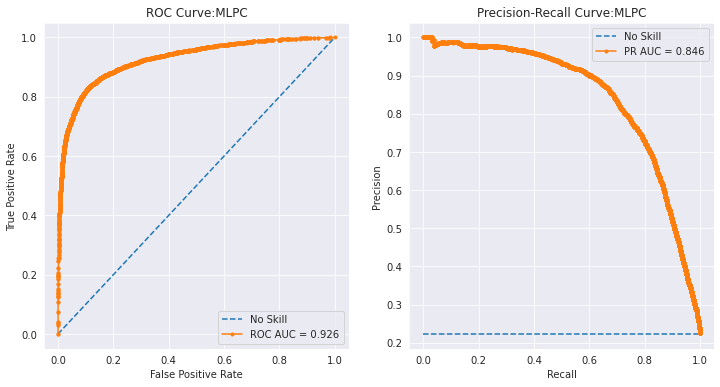

In [27]:
print("")
print(f"Training MULTILAYER PERCEPTRON CLASSIFIER")
print("")

labelCol="label"

# specify layers: 19 (features), two intermediate (8, 4), output 2 (classes)
layers=[18, 8, 4, 2]
# create the trainer and set its parameters
mlpc_classifier = MultilayerPerceptronClassifier(labelCol = "label",
                                                featuresCol = "features",
                                                layers=layers,
                                                seed=1234)
# build specific pipeline
mlpc_pipeline = build_full_pipeline(mlpc_classifier)


# choose an evaluator
evaluator = BinaryClassificationEvaluator()
evaluator.setLabelCol(labelCol)

# build the grid search pipeline
mlpc = mlpc_grid_search(mlpc_pipeline)

# start timer
start_time = time.time()

# train the model
model_mlpc = mlpc.fit(train_cached)

# stop timer
end_time = time.time()

# evaluate the trainining time in minutes 
train_time = (end_time - start_time)/60

# print the training time
print("")
print("Training time.........%6.3f min" % train_time)

# create the predictions dataset
predictions_mlpc = model_mlpc.bestModel.transform(train_cached)

# calculate auc metrics
roc_mlpc = evaluator.evaluate(predictions_mlpc, {evaluator.metricName: "areaUnderROC"})
pr_mlpc = evaluator.evaluate(predictions_mlpc, {evaluator.metricName: "areaUnderPR"})

# record the confusion matrix metrics
acc_mlpc, prec_mlpc, rec_mlpc, f1_mlpc = conf_metrics(predictions_mlpc)

# print all evaluation metrics
print("")
display_metrics(predictions_mlpc, roc_mlpc, pr_mlpc)
print("")

# print the best parameters from the grid
best_model_mlpc = model_mlpc.bestModel.stages[-1]
param_mlpc1 = best_model_mlpc.getStepSize()
param_mlpc2 = best_model_mlpc.getMaxIter()
param_mlpc3 = best_model_mlpc.getBlockSize()
print("The best hyperparameter values from the grid:")
print("stepSize:..........", param_mlpc1)
print("maxIter:...........", param_mlpc2)
print("blockSize:.........", param_mlpc3)

# plot the ROC and PR curves
plot_roc_pr_curves(predictions_mlpc, "MLPC")

### <font color='blue'>Linear Support Vector Machine</font>

In [28]:
# model_name = "Linear SVM"
def lsvc_grid_search(pipeline):
    
    model = pipeline.getStages()[-1]

    # create a list of parameters for Linear SVM
    param_lsvc = ParamGridBuilder()
    param_lsvc = param_lsvc.addGrid(model.maxIter, [100])
    param_lsvc = param_lsvc.addGrid(model.regParam, [0.0])  
    param_lsvc = param_lsvc.build()
    
    print(f"Models trained: {len(param_lsvc)}")
    
    return grid_search_model(pipeline, param_lsvc)

In [29]:
print("")
print(f"Training LINEAR SUPPORT VECTOR MACHINE")
print("")

predCol="prediction"
labelCol="label"

# instantiate the classifier
lsvc_classifier = LinearSVC(labelCol = "label",
                            featuresCol = "features")
# build specific pipeline
lsvc_pipeline = build_full_pipeline(lsvc_classifier)

# choose an evaluator
evaluator = BinaryClassificationEvaluator()
evaluator.setLabelCol(labelCol)

# build the grid search pipeline
lsvc = lsvc_grid_search(lsvc_pipeline)

# start timer
start_time = time.time()

# train the model
model_lsvc = lsvc.fit(train_cached)

# stop timer
end_time = time.time()

# evaluate the trainining time in minutes 
train_time = (end_time - start_time)/60

# print the training time
print("")
print("Training time.........%6.3f min" % train_time)

# create the predictions dataset
predictions_lsvc = model_lsvc.bestModel.transform(train_cached)

# calculate auc metrics
roc_lsvc = evaluator.evaluate(predictions_lsvc, {evaluator.metricName: "areaUnderROC"})
pr_lsvc = evaluator.evaluate(predictions_lsvc, {evaluator.metricName: "areaUnderPR"})

# record the confusion matrix metrics
acc_lsvc, prec_lsvc, rec_lsvc, f1_lsvc = conf_metrics(predictions_lsvc)

# print all evaluation metrics
print("")
display_metrics(predictions_lsvc, roc_lsvc, pr_lsvc)
print("")

# print the best parameters from the grid
best_model_lsvc = model_lsvc.bestModel.stages[-1]
param_lsvc1 = best_model_lsvc.getMaxIter()
param_lsvc2 = best_model_lsvc.getRegParam()
print("The best hyperparameter values from the grid:")
print("maxIter:..........", param_lsvc1)
print("regParam:...........", param_lsvc2)


Training LINEAR SUPPORT VECTOR MACHINE

Models trained: 1

Training time......... 0.718 min


Confusion Matrix
+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|  1.0|       1.0| 2080|
|  0.0|       1.0|  673|
|  1.0|       0.0| 1363|
|  0.0|       0.0|11322|
+-----+----------+-----+


accuracy............... 0.868
precision.............. 0.756
recall................. 0.604
F1..................... 0.671
auc_roc................ 0.886
auc_pr................. 0.756

The best hyperparameter values from the grid:
maxIter:.......... 100
regParam:........... 0.0


## <font color='blue'>Discuss the Best Model</font>

In [30]:
# create Pandas dataframe with metrics
dict_metrics = {"LinReg": [acc_lr, prec_lr, rec_lr, f1_lr, roc_lr, pr_lr],
                "DecTrees": [acc_dt, prec_dt, rec_dt, f1_dt, roc_dt, pr_dt], 
                "RandForest": [acc_rf, prec_rf, rec_rf, f1_rf, roc_rf, pr_rf],
                "GradBoost": [acc_gbt, prec_gbt, rec_gbt, f1_gbt, roc_gbt, pr_gbt],
                "MultiLPerceptron": [acc_mlpc, prec_mlpc, rec_mlpc, f1_mlpc, roc_mlpc, pr_mlpc],
                "LinearSVM": [acc_lsvc, prec_lsvc, rec_lsvc, f1_lsvc, roc_lsvc, pr_lsvc],
                "list_metrics" : ["accuracy", "precision", "recall", "f1_score", "auc_roc", "auc_pr"]
               }
df_mets = pd.DataFrame.from_dict(dict_metrics).set_index("list_metrics")
df_mets.round(3)

,LinReg,DecTrees,RandForest,GradBoost,MultiLPerceptron,LinearSVM
list_metrics,,,,,,
accuracy,0.866,0.884,0.875,0.907,0.901,0.868
precision,0.750,0.860,0.872,0.874,0.830,0.756
recall,0.600,0.573,0.514,0.682,0.702,0.604
f1_score,0.666,0.688,0.647,0.766,0.761,0.671
auc_roc,0.889,0.717,0.899,0.934,0.926,0.886
auc_pr,0.755,0.586,0.788,0.866,0.845,0.756


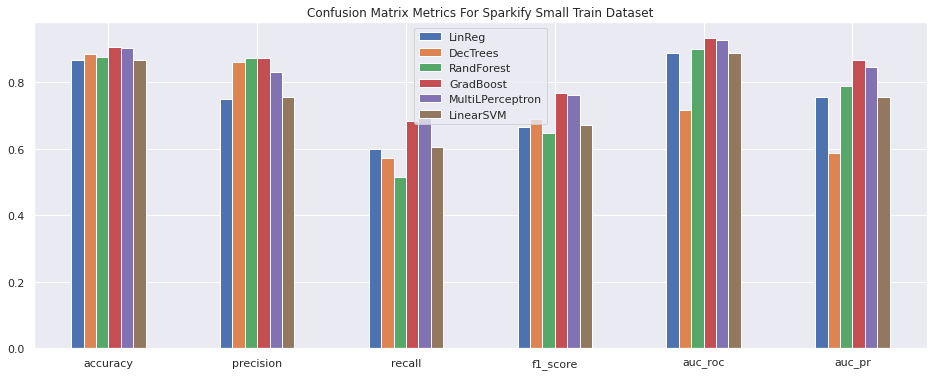

In [31]:
# adjust figure size and font size
sns.set(rc = {"figure.figsize":(16,6)})

sns.set(font_scale=1)
ax = df_mets.plot.bar(y=["LinReg", "DecTrees", "RandForest", "GradBoost", "MultiLPerceptron", "LinearSVM"], rot=0)

# create title and labels
plt.title("Confusion Matrix Metrics For Sparkify Small Train Dataset")
ax.set_xlabel("");
ax.set_ylabel("");

In [ ]:
### <font color='blue'>Gradient Boosted Trees</font>

In [ ]:
# model_name = "Gradient Boosted Trees"
def gbt_grid_search(pipeline):
    
    model = pipeline.getStages()[-1]

    # create a list of parameters for Gradient Boosted Trees
    param_gbt = ParamGridBuilder()
    param_gbt = param_gbt.addGrid(model.maxDepth, [5, 10, 15, 20])
    param_gbt = param_gbt.addGrid(model.maxIter, [20, 40, 60, 80, 100])
    param_gbt = param_gbt.addGrid(model.stepSize, [.05, .1, .15, .2])
    param_gbt = param_gbt.build()
    
    print(f"Models trained: {len(param_gbt)}")
    
    return grid_search_model(pipeline, param_gbt)

In [ ]:
print("")
print(f"Training GRADIENT BOOSTED TREES")
print("")

predCol="prediction"
labelCol="label"

# instantiate the classifier
gbt_classifier = GBTClassifier(labelCol = "label",
                                featuresCol = "features",
                                seed=1234)
# build specific pipeline
gbt_pipeline = build_full_pipeline(gbt_classifier)

# choose an evaluator
evaluator = BinaryClassificationEvaluator()
evaluator.setLabelCol(labelCol)

# build the grid search pipeline
gbt = gbt_grid_search(gbt_pipeline)

# start timer
start_time = time.time()

# train the model
model_gbt = gbt.fit(train_cached)

# stop timer
end_time = time.time()

# evaluate the trainining time in minutes 
train_time = (end_time - start_time)/60

# print the training time
print("")
print("Training time.........%6.3f min" % train_time)

# create the predictions dataset
predictions_gbt = model_gbt.bestModel.transform(train_cached)

# calculate auc metrics
roc_gbt = evaluator.evaluate(predictions_gbt, {evaluator.metricName: "areaUnderROC"})
pr_gbt = evaluator.evaluate(predictions_gbt, {evaluator.metricName: "areaUnderPR"})

# record the confusion matrix metrics
acc_gbt, prec_gbt, rec_gbt, f1_gbt = conf_metrics(predictions_gbt)

# print all evaluation metrics
print("")
display_metrics(predictions_gbt, roc_gbt, pr_gbt)
print("")

# print the best parameters from the grid
best_model_gbt = model_gbt.bestModel.stages[-1]
param_gbt1 = best_model_gbt.getMaxDepth()
param_gbt2 = best_model_gbt.getMaxIter()
param_gbt3 = best_model_gbt.getStepSize()
print("The best hyperparameter values from the grid:")
print("maxDepth:..........", param_gbt1)
print("maxIter:...........", param_gbt2)
print("stepSize:..........", param_gbt3)

# plot the ROC and PR curves
plot_roc_pr_curves(predictions_gbt, "GBT")

### <font color='blue'>Multilayer Perceptron Classifier</font>

In [ ]:
# model_name = "Multilayer Perceptron Classifier"
def mlpc_grid_search(pipeline):
    
    model = pipeline.getStages()[-1]

    # create a list of parameters for Multilayer Perceptron Classifier
    param_mlpc = ParamGridBuilder()
    param_mlpc = param_mlpc.addGrid(model.stepSize, [.03])
    param_mlpc = param_mlpc.addGrid(model.maxIter, [100]) 
    param_mlpc = param_mlpc.build()
    
    print(f"Models trained: {len(param_mlpc)}")
    
    return grid_search_model(pipeline, param_mlpc)

In [ ]:
print("")
print(f"Training MULTILAYER PERCEPTRON CLASSIFIER")
print("")

labelCol="label"

# specify layers: 19 (features), two intermediate (8, 4), output 2 (classes)
layers=[18, 8, 4, 2]
# create the trainer and set its parameters
mlpc_classifier = MultilayerPerceptronClassifier(labelCol = "label",
                                                featuresCol = "features",
                                                layers=layers,
                                                seed=1234)
# build specific pipeline
mlpc_pipeline = build_full_pipeline(mlpc_classifier)


# choose an evaluator
evaluator = BinaryClassificationEvaluator()
evaluator.setLabelCol(labelCol)

# build the grid search pipeline
mlpc = mlpc_grid_search(mlpc_pipeline)

# start timer
start_time = time.time()

# train the model
model_mlpc = mlpc.fit(train_cached)

# stop timer
end_time = time.time()

# evaluate the trainining time in minutes 
train_time = (end_time - start_time)/60

# print the training time
print("")
print("Training time.........%6.3f min" % train_time)

# create the predictions dataset
predictions_mlpc = model_mlpc.bestModel.transform(train_cached)

# calculate auc metrics
roc_mlpc = evaluator.evaluate(predictions_mlpc, {evaluator.metricName: "areaUnderROC"})
pr_mlpc = evaluator.evaluate(predictions_mlpc, {evaluator.metricName: "areaUnderPR"})

# record the confusion matrix metrics
acc_mlpc, prec_mlpc, rec_mlpc, f1_mlpc = conf_metrics(predictions_mlpc)

# print all evaluation metrics
print("")
display_metrics(predictions_mlpc, roc_mlpc, pr_mlpc)
print("")

# print the best parameters from the grid
best_model_mlpc = model_mlpc.bestModel.stages[-1]
param_mlpc1 = best_model_mlpc.getStepSize()
param_mlpc2 = best_model_mlpc.getMaxIter()
param_mlpc3 = best_model_mlpc.getBlockSize()
print("The best hyperparameter values from the grid:")
print("stepSize:..........", param_mlpc1)
print("maxIter:...........", param_mlpc2)
print("blockSize:.........", param_mlpc3)

# plot the ROC and PR curves
plot_roc_pr_curves(predictions_mlpc, "MLPC")

In [52]:
def plot_roc_pr_curves(predictions_model1, predictions_model2):
    
    """
    Plots the ROC and PR curves for two models on the same graphs.
    
    INPUT:
        predictions_model1 (PySpark dataframe) - contains probability predictions for the first model
        predictions_model2 (PySpark dataframe) - contains probability predictions for the second model
        
    OUTPUT:
        none - two plots are displayed
        
    """
    
    # transform predictions PySpark dataframe into Pandas dataframe
    pred1_pandas = predictions_model1.select(predictions_model1.label, 
                                             predictions_model1.probability).toPandas()
    pred2_pandas = predictions_model2.select(predictions_model2.label, 
                                             predictions_model2.probability).toPandas()
    
    # calculate roc_auc scores
    roc_auc1 = roc_auc_score(pred1_pandas.label, pred1_pandas.probability.str[1])
    # calculate roc_auc scores
    roc_auc2 = roc_auc_score(pred2_pandas.label, pred2_pandas.probability.str[1])
    
    # generate a no skill prediction (majority class)
    ns_probs = [0 for _ in range(len(pred1_pandas.label))]
    
    # calculate roc curves for model 1
    fpr1, tpr1, _ = roc_curve(pred1_pandas.label, pred1_pandas.probability.str[1])
    ns_fpr1, ns_tpr1, _ = roc_curve(pred1_pandas.label, ns_probs)
    
    # calculate roc curves for model 2
    fpr2, tpr2, _ = roc_curve(pred2_pandas.label, pred2_pandas.probability.str[1])
    ns_fpr2, ns_tpr2, _ = roc_curve(pred2_pandas.label, ns_probs)
    
    # calculate precision, recall for each threshold for the first model
    precision1, recall1, _ = precision_recall_curve(pred1_pandas.label, pred1_pandas.probability.str[1])
    # calculate pr auc score
    pr_auc1 = auc(recall1, precision1)
    
    # calculate precision, recall for each threshold for the second model
    precision2, recall2, _ = precision_recall_curve(pred2_pandas.label, pred2_pandas.probability.str[1])
    # calculate pr auc score
    pr_auc2 = auc(recall2, precision2)

    # create figure which contains two subplots
    plt.figure(figsize=[12,6])
    
    plt.subplot(121)
    
    # plot the roc curve for the model1
    plt.plot(ns_fpr1, ns_tpr1, linestyle='--', label='No Skill')
    plt.plot(fpr1, tpr1, marker='.', color='firebrick', label='ROC AUC MLPC = %.3f' % (roc_auc1))
    plt.plot(fpr2, tpr2, marker='.', color='green', label='ROC AUC GBT= %.3f' % (roc_auc2))
    
    # axis labels
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    # show the legend
    plt.legend()
    # figure title
    plt.title("ROC Curves")
    
    plt.subplot(122)
    
    # plot the precision-recall curves
    
    #ns_line = len(pred_pandas[pred_pandas.label==1]) / len(pred_pandas.label)
    #plt.plot([0, 1], [ns_line, ns_line], linestyle='--', label='No Skill')
    plt.plot(recall1, precision1, marker='.', color="firebrick", label='PR AUC MLPC = %.3f' % (pr_auc1))
    plt.plot(recall2, precision2, marker='.', color="green", label='PR AUC GBT = %.3f' % (pr_auc2))
    
    # axis labels
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    # show the legend
    plt.legend()
    # figure title
    plt.title("Precision-Recall Curves")

    # show the plot
    plt.show()

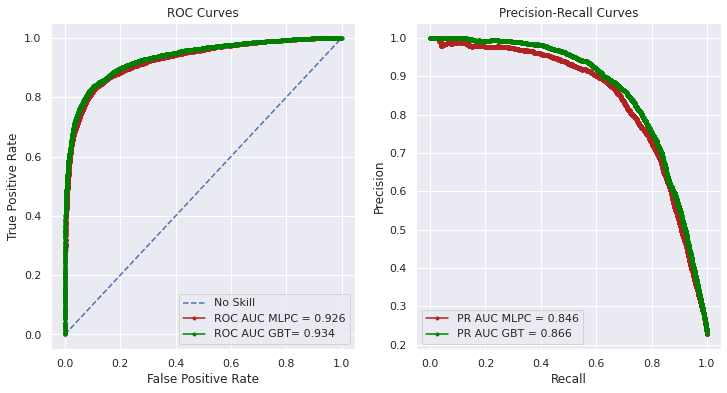

In [53]:
plot_roc_pr_curves(predictions_mlpc, predictions_gbt)

In [ ]:
#feature importance 

xticks=columns
plt.figure(figsize=(12,8))

sns.barplot(x=np.linspace(0,len(xticks),len(xticks)+1),
            y=rfmodel.featureImportances.values)
plt.xticks(ticks=np.linspace(0,len(xticks),len(xticks)+1),labels=xticks, rotation=30)
plt.ylabel('Coefficients')
plt.title('Feature Importances')
%matplot plt